<font size="10">Learning Global Linearizing Transformations with Koopman Eigenfunctions</font>

<font size="4">This notebook employs an autoencoder neural network structure to develop a data-driven method of discovering Koopman eigenfunctions that can be used to linearize the dynamics of a nonlinear system. Precisely, the r-dimensional output of the encoder represents a basis of r eigenfunctions of the associated Koopman operator. The eigenfunctions are then re-combined as a linear combination to build the decoder function, whose outputs constitute the state-space observables. The training process also simultaneously discovers the eigenvalues associated to each Koopman eigenfunction.</font>

<font size="4">The linearization method is applied to the simple two-dimensional nonlinear map $f = (f_1,f_2):\mathbb{R}^2 \to \mathbb{R}^2$ whose right-hand-side is given by</font> 
    
$f_1(x_1,x_2) = \lambda_1 x_1,$
    
$f_2(x_1,x_2) = \lambda_2 (x_2 - x_1^2).$
    
<font size="4">For this mapping the linearizing eigenfunctions are known to be the set:</font> 
    
$\psi_1(x_1,x_2) = x_1, \quad  \psi_2(x_1,x_2) = x_2 - \frac{\lambda_2}{\lambda_2 - \lambda_1^2}x_1^2, \quad \psi_3(x_1,x_2) = x_1^2$

    
<font size="4">with corresponding eigenfunctions $\mu_1 = \lambda_1$, $\mu_2 = \lambda_2$, and $\mu_3 = \lambda_1^2$, respectively. For a demonstration of these results see the examples in Section 2.3 of the accompanying textbook.</font> 


<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2D nonlinear map for example
def map(x,lam1 = 1.5, lam2 = 0.5):
    
    xnp1 = [lam1*x[0], lam2*(x[1] - x[0]**2)]
    
    return xnp1

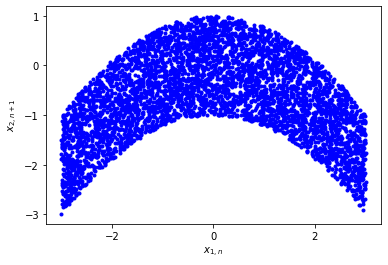

In [3]:
# Sample random points in the domain [-1,1]^2 and determine their image under map in previious block 

# Initializations
N = 5000 # number of samples
xn = np.zeros((N,2))
xnp1 = np.zeros((N,2))

# Map parameters
lam1 = 1.5
lam2 = 0.5

for n in range(1,N):
    xn[n] = 4*np.random.rand(2) - 2 
    xnp1[n] = map(xn[n], lam1, lam2) # forward iterate of the toy model map from Exercise 2.3.1

# Plot the image of the unit square under the map for visualization
plt.plot(xnp1[:,0],xnp1[:,1],'b.')
plt.xlabel('$x_{1,n}$',)
plt.ylabel('$x_{2,n+1}$')
plt.rc('font', size= 16)

In [4]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 3,
                 activation = 'selu',
                 numblksIn = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Real-valued Koopman eigenvalues
    #    ---> Set 'trainable' to False to fix eigenvalues and True for variable eigenvalues
    self.a1 = tf.Variable(1.5, trainable = True) 
    self.a2 = tf.Variable(0.5, trainable = True) 
    self.a3 = tf.Variable(2.25, trainable = True)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function: single layer linear output
    self.decoder = tf.keras.Sequential()
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= tf.keras.activations.linear, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x)
    
    # Build foward iterates under linear map
    y1np1 = self.a1*encoded[:,0]
    y2np1 = self.a2*encoded[:,1]
    y3np1 = self.a3*encoded[:,2]
    
    # Stack forward iterates of linear map back together
    encoded_p1 = tf.stack([y1np1, y2np1, y3np1], axis = -1)
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss 
    xnp1_1 = lam1*x[:,0]
    xnp1_2 = lam2*(x[:,1] - tf.math.square(x[:,0]))
    xnp1 = tf.stack([xnp1_1, xnp1_2], axis = -1)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # Linear map (g) loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    return decoded

In [5]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 2 # number of variables in the original nonlinear map
size_y = 3 # number of variables in the linear Koopman map
activation = 'selu' # nonlinear activation function at each NN layer of the encoder
learning_rate = 0.00005
numblks_in = 6 # number of layers for the encoder NN

In [40]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

# Increase epochs for better training. It has been set low to minimize the output.
conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 10, verbose = 1)

Epoch 1/10
157/157 [==============================] - 3s 3ms/step - loss: 7.9292
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 6.3627
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 5.2636
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 4.4266
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 3.7133
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 3.2680
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.9907
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 2.7980
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 2.6420
Epoch 10/10
157/157 [==============================] - 1s 4ms/step - loss: 2.5025


In [29]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues (assumed real)')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.numpy())
print('a2 = ', conjugacy.a2.numpy())
print('a3 = ', conjugacy.a3.numpy())
print('')
print('True Koopman Eigenvalues')
print('------------------------')
print('a1 = ', lam1)
print('a2 = ', lam2)
print('a3 = ', lam1**2)
print('')
print('NOTE: Discovered eigenvalues may appear in a different order from the true values')

print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.layers[1].get_weights()[0]
print(linear_weights)

Discovered Koopman Eigenvalues (assumed real)
---------------------------------------------
a1 =  2.2466173
a2 =  0.49964687
a3 =  1.4996363

True Koopman Eigenvalues
------------------------
a1 =  1.5
a2 =  0.5
a3 =  2.25

NOTE: Discovered eigenvalues may appear in a different order from the true values

Weights of the linear layer
------------------------
[[ 1.4584257e-02  1.5211235e+00]
 [-7.9419382e-04  1.3526629e+00]
 [ 1.7073458e+00 -2.1877312e-03]]


In [30]:
# Output to MATLAB

x = np.mgrid[-2:2.01:0.01, -2:2.01:0.01].reshape(2,-1).T
koop = conjugacy.encoder(x) # Output of the Koopman observables - shape = [length(x), size_y]

import scipy.io

# Save data as .mat file
#scipy.io.savemat('koopObs_fixed.mat', dict(x = x, koop = koop.numpy()))
scipy.io.savemat('koopObs_variable.mat', dict(x = x, koop = koop.numpy()))
# This data is used in the MATLAB script make_plots.m to plot 
#      the Koopman observables on the square [-2,2] x [-2,2]

In [31]:
# Save network config
#!mkdir -p saved_conjugacy_networks
#conjugacy.save('saved_conjugacy_networks/global_linear_real_fixed') # For fixed eigenvalues
conjugacy.save('saved_conjugacy_networks/global_linear_real_variable') # For variable eigenvlues

INFO:tensorflow:Assets written to: saved_conjugacy_networks/global_linear_real_variable/assets


In [ ]:
# Load and view saved models
# --> Differences in models that can be loaded: 
#       1) _fixed suffix means the Koopman eigenvalues were fixed and only eigenfunctions were identified
#       2) _variable suffix means the Koopman eigenvalues were identified during network training

# Load fixed eigenvalues model
conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_real_fixed')

# Load variable eigenvalues model
#conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_real_variable')

# Neural network summary
conjugacy.summary()

# Compile the network
conjugacy.compile()

# Check eigenvalues
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.numpy())
print('a2 = ', conjugacy.a2.numpy())
print('a3 = ', conjugacy.a3.numpy())
print('---------------------------------------------')

# Print the weights of the linear layer for inspection
print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.layers[1].get_weights()[0]
print(linear_weights)

<font size="6">**Another Network Architecture**</font>

<font size="4">The code that follows trains an autoencoder network to discover both the real and imaginary parts of the eigenvalues/eigenvectors. Since the true eigenvalues/eigenvectors are real, we should expect the imaginary parts to all be zero.</font>

<font size="4">Saved model used to produce the results in the text is in the `saved_conjugacy_networks' folder under the name 'global_linear_complex'.</font> 

In [30]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 6,
                 activation = 'selu',
                 numblksIn = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Real-valued Koopman eigenvalues
    #    ---> Set 'trainable' to False to fix eigenvalues and True for variable eigenvalues
    self.a1 = tf.Variable(1.5, trainable = True) 
    self.a2 = tf.Variable(0.5, trainable = True) 
    self.a3 = tf.Variable(2.25, trainable = True)
    self.b1 = tf.Variable(0.0, trainable = True) 
    self.b2 = tf.Variable(0.0, trainable = True) 
    self.b3 = tf.Variable(0.0, trainable = True)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function: single layer linear output
    self.decoder = tf.keras.Sequential()
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= tf.keras.activations.linear, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           use_bias=False))
    
    
  def call(self, x):
    encoded = self.encoder(x)
    
    # Build foward iterates under linear map
    y1np1 = self.a1*encoded[:,0] + self.b1*encoded[:,1]
    y2np1 = -self.b1*encoded[:,0] + self.a1*encoded[:,1]
    y3np1 = self.a2*encoded[:,2] + self.b2*encoded[:,3]
    y4np1 = -self.b2*encoded[:,2] + self.a2*encoded[:,3]
    y5np1 = self.a3*encoded[:,4] + self.b3*encoded[:,5]
    y6np1 = -self.b3*encoded[:,4] + self.a3*encoded[:,5]
    
    # Stack forward iterates of linear map back together
    encoded_p1 = tf.stack([y1np1, y2np1, y3np1, y4np1, y5np1, y6np1], axis = -1)
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss 
    xnp1_1 = lam1*x[:,0]
    xnp1_2 = lam2*(x[:,1] - tf.math.square(x[:,0]))
    xnp1 = tf.stack([xnp1_1, xnp1_2], axis = -1)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # Linear map (g) loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    return decoded

In [35]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 2 # number of variables in the original nonlinear map
size_y = 6 # number of variables in the linear Koopman map
activation = 'selu' # nonlinear activation function at each NN layer of the encoder
learning_rate = 0.000001
numblks_in = 6 # number of layers for the encoder NN

In [41]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

# Increase epochs for better training. It has been set low to minimize the output.
conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 10, verbose = 1)

Epoch 1/10
157/157 [==============================] - 2s 3ms/step - loss: 6.2236
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 4.7401
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 3.8349
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 3.2515
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.8431
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.5609
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.3613
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2013
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.0581
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - loss: 1.9382


In [43]:
# Print Discovered Eigenvalues
print('Discovered Koopman Eigenvalues - Real parts')
print('---------------------------------------------')
print('a1 = ', conjugacy.a1.numpy())
print('a2 = ', conjugacy.a2.numpy())
print('a3 = ', conjugacy.a3.numpy())
print('')
print('Discovered Koopman Eigenvalues - Imaginary parts')
print('---------------------------------------------')
print('b1 = ', conjugacy.b1.numpy())
print('b2 = ', conjugacy.b2.numpy())
print('b3 = ', conjugacy.b3.numpy())


# Print the weights of the linear layer for inspection
print('')
print('Weights of the linear layer')
print('------------------------')
linear_weights = conjugacy.layers[1].get_weights()[0]
print(linear_weights)

Discovered Koopman Eigenvalues - Real parts
---------------------------------------------
a1 =  1.4990752
a2 =  0.49936298
a3 =  2.2649937

Discovered Koopman Eigenvalues - Imaginary parts
---------------------------------------------
b1 =  -0.0057560285
b2 =  0.0012338609
b3 =  0.01593717

Weights of the linear layer
------------------------
[[ 1.2327965e-01 -1.4950383e-03]
 [-1.7708097e-01 -1.3781390e-03]
 [-1.7731042e-04  2.1218640e-01]
 [-4.5594113e-04 -2.3747103e-01]
 [-1.4900496e-03 -1.5683679e-01]
 [ 1.3708884e-02 -1.0410752e-01]]


In [38]:
# Save network config
#!mkdir -p saved_conjugacy_networks
#conjugacy.save('saved_conjugacy_networks/global_linear_complex') # For variable eigenvlues

INFO:tensorflow:Assets written to: saved_conjugacy_networks/global_linear_complex/assets


In [45]:
# Load fixed eigenvalues model
conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_complex')

# Load variable eigenvalues model
#conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/global_linear_real_variable')

# Neural network summary
conjugacy.summary()

# Compile the network
conjugacy.compile()

Model: "conjugacy_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 6)                 202806    
                                                                 
 sequential_19 (Sequential)  (None, 2)                 12        
                                                                 
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Output to MATLAB

x = np.mgrid[-2:2.01:0.01, -2:2.01:0.01].reshape(2,-1).T
koop = conjugacy.encoder(x) # Output of the Koopman observables - shape = [length(x), size_y]

import scipy.io

# Save data as .mat file
#scipy.io.savemat('koopObs_fixed.mat', dict(x = x, koop = koop.numpy()))
scipy.io.savemat('koopObs_complex.mat', dict(x = x, koop = koop.numpy()))
# This data is used in the MATLAB script make_plots.m to plot 
#      the Koopman observables on the square [-2,2] x [-2,2]